# Proyecto 3 - Visión por Computadora
## Integrantes:
- Mario Guerra - Carné: 21008
- Javier Alvarado - Carné: 21188
- Emilio Solano - Carné: 21212

### Inciso 1. Elección de imagen base.

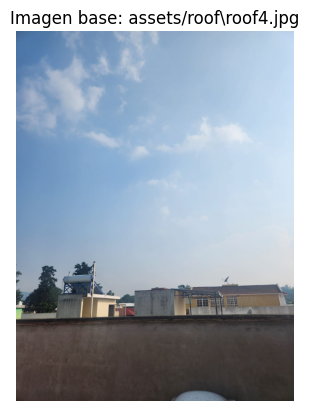

In [7]:
import cv2
import glob
import matplotlib.pyplot as plt

# Cargar imágenes
images = sorted(glob.glob("assets/roof/*.jpg"))
base_idx = len(images) // 2
image_base = cv2.imread(images[base_idx])
image_base_rgb = cv2.cvtColor(image_base, cv2.COLOR_BGR2RGB)

# Mostrar imagen base
plt.imshow(image_base_rgb)
plt.title(f"Imagen base: {images[base_idx]}")
plt.axis('off')
plt.show()


### Inciso 2. Detección de correspondencias y cálculo de homografías.

In [8]:
import numpy as np

def matching_pairs(img1, img2):
    orb = cv2.ORB_create(nfeatures=2000)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Matching con fuerza bruta
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Convertir a puntos flotantes
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Calcular homografía con RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H, kp1, kp2, matches, mask


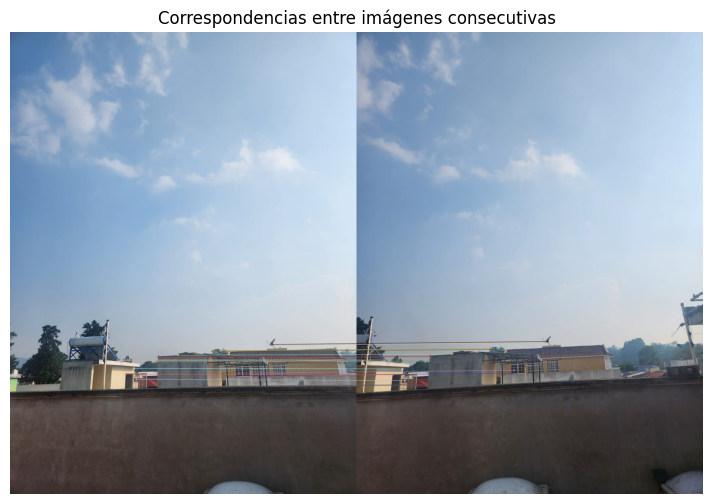

In [9]:
# Comparar imagen base con su vecina siguiente
img1 = cv2.imread(images[base_idx])
img2 = cv2.imread(images[base_idx + 1])

H, kp1, kp2, matches, mask = matching_pairs(img1, img2)

# Dibujar matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=2)
img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16, 6))
plt.imshow(img_matches_rgb)
plt.title("Correspondencias entre imágenes consecutivas")
plt.axis('off')
plt.show()


### Inciso 3. Warping

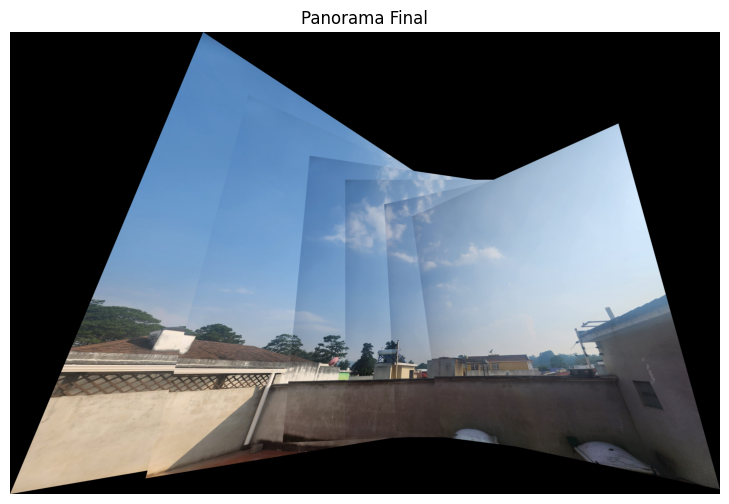

In [10]:
import numpy as np

paths = sorted(glob.glob("assets/roof/*.jpg"))
imgs = [cv2.imread(p) for p in paths]
b = len(imgs)//2

Hs = []
for i in range(len(imgs)-1):
    H,_,_,_,_ = matching_pairs(imgs[i], imgs[i+1])
    Hs.append(H)

G = [None]*len(imgs)
G[b] = np.eye(3, dtype=np.float64)

# para i < b
for i in range(b-1, -1, -1):
    G[i] = Hs[i] @ G[i+1]

# para i > b
for i in range(b+1, len(imgs)):
    G[i] = np.linalg.inv(Hs[i-1]) @ G[i-1]

corners = np.array([[0,0],[0,1],[1,1],[1,0]], dtype=np.float32)
all_pts = []
for i,im in enumerate(imgs):
    h,w = im.shape[:2]
    pts = np.array([[0,0],[w,0],[w,h],[0,h]], dtype=np.float32).reshape(-1,1,2)
    warped = cv2.perspectiveTransform(pts, G[i])
    all_pts.append(warped)

all_pts = np.vstack(all_pts)
x_min, y_min = all_pts[:,:,0].min(), all_pts[:,:,1].min()
x_max, y_max = all_pts[:,:,0].max(), all_pts[:,:,1].max()

# tamaño y offsets
W_pano = int(np.ceil(x_max - x_min))
H_pano = int(np.ceil(y_max - y_min))
dx, dy = -x_min, -y_min

pano = np.zeros((H_pano, W_pano, 3), dtype=np.uint8)

for i,im in enumerate(imgs):
    # construir matriz de desplazamiento + homografía
    T = np.array([[1,0,dx],
                  [0,1,dy],
                  [0,0,1]], dtype=np.float64)
    M = T @ G[i]
    cv2.warpPerspective(im, M, (W_pano, H_pano),
                        dst=pano,
                        flags=cv2.INTER_LINEAR,
                        borderMode=cv2.BORDER_TRANSPARENT)


pano_rgb = cv2.cvtColor(pano, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,6))
plt.imshow(pano_rgb)
plt.axis('off')
plt.title("Panorama Final")
plt.show()


### Inciso 4. Blending

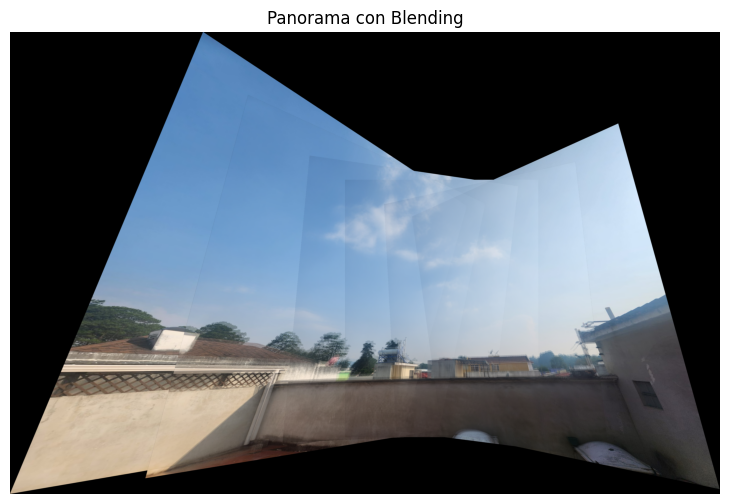

In [11]:
pano_blend = np.zeros((H_pano, W_pano, 3), dtype=np.float32)
accumulator = np.zeros((H_pano, W_pano), dtype=np.float32)  # contar cuántas veces se escribe un píxel

for i, im in enumerate(imgs):
    h, w = im.shape[:2]
    
    # transformación global con desplazamiento
    T = np.array([[1, 0, dx],
                  [0, 1, dy],
                  [0, 0, 1]], dtype=np.float64)
    M = T @ G[i]
    
    # imagen de máscara blanca del mismo tamaño que imagen original
    mask = np.ones((h, w), dtype=np.uint8) * 255
    
    # mapas para la imagen y máscara transformadas
    warped_im = cv2.warpPerspective(im.astype(np.float32), M, (W_pano, H_pano),
                                    flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    
    warped_mask = cv2.warpPerspective(mask, M, (W_pano, H_pano),
                                      flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT)
    
    # máscara binaria para sumar píxeles válidos
    mask_valid = (warped_mask > 0).astype(np.float32)
    
    # sumar las imágenes transformadas y acumular cantidad de veces que se suma cada pixel
    for c in range(3):
        pano_blend[:, :, c] += warped_im[:, :, c] * mask_valid
    
    accumulator += mask_valid

# evitar división por cero
accumulator[accumulator == 0] = 1

# dividir acumulado por la cantidad de veces que se escribió cada pixel
for c in range(3):
    pano_blend[:, :, c] /= accumulator

pano_blend = np.clip(pano_blend, 0, 255).astype(np.uint8)

pano_blend_rgb = cv2.cvtColor(pano_blend, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 6))
plt.imshow(pano_blend_rgb)
plt.axis('off')
plt.title("Panorama con Blending")
plt.show()

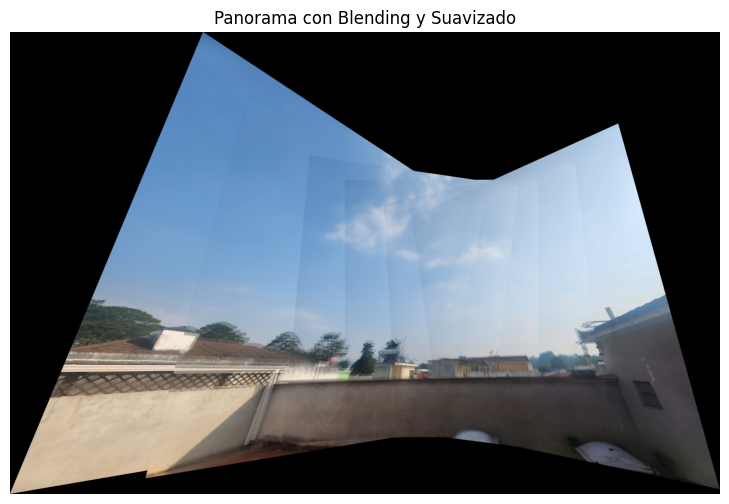

In [ ]:
pano_smooth = cv2.bilateralFilter(pano_blend, d=9, sigmaColor=75, sigmaSpace=75)

# Mostrar panorama suavizado
pano_smooth_rgb = cv2.cvtColor(pano_smooth, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 6))
plt.imshow(pano_smooth_rgb)
plt.axis('off')
plt.title("Panorama con Blending y Suavizado")
plt.show()

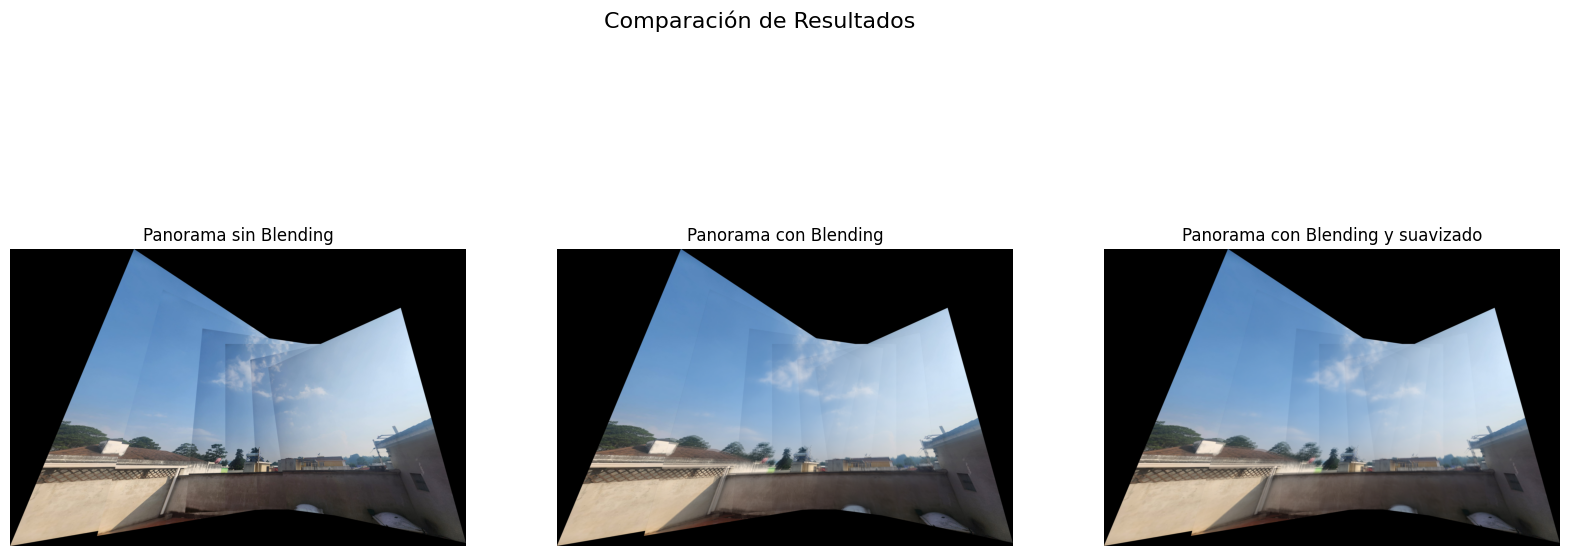

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.imshow(pano_rgb)
plt.title("Panorama sin Blending")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(pano_blend_rgb)
plt.title("Panorama con Blending")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pano_smooth)
plt.title("Panorama con Blending y suavizado")
plt.axis('off')

plt.suptitle("Comparación de Resultados", fontsize=16)
plt.show()